# MNIST 

This exemple is an implementation of federated learning using Substra's Distributed Learning Contributivity.

This is based on both [existing resources on MNIST](https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e) and [precedent implementation of this dataset for the standalone application](https://github.com/SubstraFoundation/distributed-learning-contributivity/blob/master/datasets/dataset_mnist.py).

This notebook will be focused on importing manually the dataset, do a bit of preprocessing and build our objects to run a collaborative round.


## Prerequisites

In order to run this example, you'll need to:

* use python 3.7 +
* install requierements from the requirements.txt file
* install this package https://test.pypi.org/project/pkg-test-distributed-learning-contributivity/0.0.5/



In [34]:
!pip install -r requirements.txt
!pip install -i https://test.pypi.org/simple/ subtest==0.0.0.6

Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: subtest
    Found existing installation: subtest 0.0.0.5
    Uninstalling subtest-0.0.0.5:
      Successfully uninstalled subtest-0.0.0.5


ERROR: subtest 0.0.0.6 has requirement ruamel.yaml==0.16.10, but you'll have ruamel-yaml 0.15.87 which is incompatible.


In [24]:
# imports
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

In [36]:
# Object and methodes needed in order to run a collaborative round
from subtest.dataset import Dataset
from subtest.scenario import Scenario, run_scenario

# Create custom scenario handling mandatory parametters

These parametter describe how many partners will be created and how much proportion they will have in the dataset.

We can use more advanced samples split options in order to finely tune the data distribution between partners.

In [37]:
scenario_params = {
    'partners_count': 3,
    'amounts_per_partner': [0.2, 0.5, 0.3],
}

# Set values for optinal parametters

We want our training to go for 10 epochs and 3 minibatches per epoch.

In [38]:
scenario_params['epoch_count'] = 10
scenario_params['minibatch_count'] = 3

#### Every other parametter will be set to its default value

We might consider :

- Datas will be split randomly between partner
- The learning approach is 'fedavg' for federated averaging 
- Weights will be averaged uniformally, different weights can be applyed for each partner

The learning approachs are built-in paramatter that can be set easly. There are currrently 4 differents approachs.


#### More details at : https://github.com/SubstraFoundation/distributed-learning-contributivity

# Define scenario

We specify our experiment path used to output graphs and results.

We can now create the scenario that will handle every parametter

In [39]:
experiment_path = Path(r"C:\GitHub\distributed-learning-contributivity\experiments\MNIST_experiment")

current_scenario = Scenario(
        scenario_params,
        experiment_path
    )

2020-08-19 12:12:52.677 | DEBUG    | subtest.scenario:__init__:54 - Dataset selected: mnist
2020-08-19 12:12:52.677 | DEBUG    | subtest.scenario:__init__:89 - Computation use the full dataset for scenario #1
2020-08-19 12:12:52.740 | INFO     | subtest.scenario:__init__:281 - ### Description of data scenario configured:
2020-08-19 12:12:52.740 | INFO     | subtest.scenario:__init__:282 -    Number of partners defined: 3
2020-08-19 12:12:52.741 | INFO     | subtest.scenario:__init__:283 -    Data distribution scenario chosen: random
2020-08-19 12:12:52.741 | INFO     | subtest.scenario:__init__:284 -    Multi-partner learning approach: fedavg
2020-08-19 12:12:52.742 | INFO     | subtest.scenario:__init__:285 -    Weighting option: uniform
2020-08-19 12:12:52.742 | INFO     | subtest.scenario:__init__:286 -    Iterations parameters: 10 epochs > 3 mini-batches > 8 gradient updates per pass
2020-08-19 12:12:52.742 | INFO     | subtest.scenario:__init__:292 - ### Data loaded: mnist
2020-08

# Create Data Set

For this experiment we use the well known MNIST dataset.

This exemple is also avilable using the standalone app specifying in the config file : dataset_name: - 'mnist'

In [40]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0],  28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

input_shape = (28, 28, 1)
num_classes = 10

# Create Preprocessing function

In [41]:
def preprocess_dataset_labels(y):
    y = np_utils.to_categorical(y, 10)
    return y

# Create Model

In [42]:
def generate_new_model_for_dataset():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Assignate dataset to scenario

In [43]:
current_scenario.dataset = Dataset(
    "my_dataset",
    X_train,
    X_test,
    y_train,
    y_test,
    input_shape,
    num_classes,
    preprocess_dataset_labels,
    generate_new_model_for_dataset
)

# Legacy
current_scenario.partners_list = []

# Split train and validation sets

This is a mandatory step to provide an unbiaised evaluation of the model performance.

In [44]:
current_scenario.dataset.train_val_split()

# Run scenario

The actual training phase of our federated learning exemple ! 

In [45]:
run_scenario(current_scenario)

2020-08-19 12:12:53.270 | INFO     | subtest.scenario:split_data:536 - ### Splitting data among partners:
2020-08-19 12:12:53.270 | INFO     | subtest.scenario:split_data:537 -    Simple split performed.
2020-08-19 12:12:53.271 | INFO     | subtest.scenario:split_data:538 -    Nb of samples split amongst partners: 38880
2020-08-19 12:12:53.272 | INFO     | subtest.scenario:split_data:540 -    Partner #0: 7776 samples with labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-08-19 12:12:53.272 | INFO     | subtest.scenario:split_data:540 -    Partner #1: 19440 samples with labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-08-19 12:12:53.272 | INFO     | subtest.scenario:split_data:540 -    Partner #2: 11664 samples with labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-08-19 12:12:53.464 | DEBUG    | subtest.scenario:compute_batch_sizes:584 -    Compute batch sizes, partner #0: 324
2020-08-19 12:12:53.465 | DEBUG    | subtest.scenario:compute_batch_sizes:584 -    Compute batch sizes, partner #1: 810
2020-08-19

2020-08-19 12:13:35.413 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > Minibatch 02/02 > Partner id #1 (1/2) > val_acc: 0.85
2020-08-19 12:13:36.122 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > Minibatch 02/02 > Partner id #2 (2/2) > val_acc: 0.85
2020-08-19 12:13:36.125 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 12:13:36.420 | INFO     | subtest.multi_partner_learning:compute_test_score:184 -    Model evaluation at the end of the epoch: ['0.472', '0.858']
2020-08-19 12:13:36.421 | DEBUG    | subtest.multi_partner_learning:compute_test_score:187 -       Checking if early stopping criteria are met:
2020-08-19 12:13:36.422 | DEBUG    | subtest.multi_partner_learning:compute_test_score:197 -          -> Early stopping criteria are not met, continuing with training.
2020-08-19 12:13:36.477 |

2020-08-19 12:13:52.670 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 12:13:52.670 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°0 of epoch n°4, init aggregated model for each partner with models from previous round
2020-08-19 12:13:53.846 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 04/09 > Minibatch 00/02 > Partner id #0 (0/2) > val_acc: 0.96
2020-08-19 12:13:54.601 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 04/09 > Minibatch 00/02 > Partner id #1 (1/2) > val_acc: 0.95
2020-08-19 12:13:55.299 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 04/09 > Minibatch 00/02 > Partner id #2 (2/2) > val_acc: 0.95
2020-08-19 12:13:55.302 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_

2020-08-19 12:14:10.890 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 12:14:10.891 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°1 of epoch n°6, init aggregated model for each partner with models from previous round
2020-08-19 12:14:12.050 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 01/02 > Partner id #0 (0/2) > val_acc: 0.97
2020-08-19 12:14:12.772 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 01/02 > Partner id #1 (1/2) > val_acc: 0.97
2020-08-19 12:14:13.463 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 01/02 > Partner id #2 (2/2) > val_acc: 0.97
2020-08-19 12:14:13.466 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_

2020-08-19 12:14:28.986 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 12:14:28.986 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°2 of epoch n°8, init aggregated model for each partner with models from previous round
2020-08-19 12:14:30.169 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 02/02 > Partner id #0 (0/2) > val_acc: 0.97
2020-08-19 12:14:30.919 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 02/02 > Partner id #1 (1/2) > val_acc: 0.98
2020-08-19 12:14:31.617 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 02/02 > Partner id #2 (2/2) > val_acc: 0.98
2020-08-19 12:14:31.620 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_

0

# Results

We can see every parametter used pre and post training.

In [46]:
df_results = current_scenario.to_dataframe()
print(df_results.columns)

Index(['aggregation_weighting', 'dataset_fraction_per_partner', 'dataset_name',
       'epoch_count', 'final_relative_nb_samples',
       'gradient_updates_per_pass_count', 'is_early_stopping',
       'learning_computation_time_sec', 'minibatch_count',
       'mpl_nb_epochs_done', 'mpl_test_score',
       'multi_partner_learning_approach', 'nb_samples_used', 'partners_count',
       'samples_split_description', 'scenario_name', 'short_scenario_name',
       'test_data_samples_count', 'train_data_samples_count'],
      dtype='object')


#### Our score :

In [47]:
print("Approach used :", df_results.multi_partner_learning_approach[0])
print("Model accuracy :", df_results.mpl_test_score[0])
print(df_results.aggregation_weighting)

Approach used : fedavg
Model accuracy : 0.9812999963760376
0    uniform
Name: aggregation_weighting, dtype: object


## Extract model 

We can extract our model and save it for actual use

In [48]:
model = current_scenario.mpl.get_model()

In [49]:
model.evaluate(X_test, preprocess_dataset_labels(y_test))

10000/10000 [==============================] - 1s 72us/step


[0.05420466448860243, 0.9812999963760376]

## Let's play  a bit more with results

First, let's see how our loss behaves

In [50]:
losses = current_scenario.mpl.loss_collective_models
print(losses)

[0.7538483274777731, 0.47222468225161235, 0.2783281849225362, 0.18476901535193124, 0.13436979361375173, 0.10136696583032608, 0.09608102879921596, 0.07877941395839055, 0.06860512799024582, 0.06405391338467598]


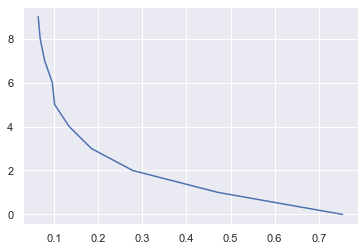

In [51]:
y = range(len(losses))
x = losses

sns.lineplot(x=x, y=y)        

### Let's see how our accuracy score goes between each partner and compare it with aggregated model performance

In [52]:
x= current_scenario.mpl.score_matrix_per_partner
print(x)

[[[0.59208333 0.53775001 0.49266666]
  [0.73141664 0.75641668 0.73883331]
  [0.73408335 0.77675003 0.77733332]]

 [[0.77416664 0.78841668 0.82833332]
  [0.82366669 0.84025002 0.87708336]
  [0.85083336 0.85441667 0.85366666]]

 [[0.89233333 0.89583331 0.87966669]
  [0.87583333 0.91883332 0.90041667]
  [0.9058333  0.91241664 0.91858333]]

 [[0.92416668 0.92891669 0.92374998]
  [0.94008332 0.94800001 0.94383335]
  [0.93058336 0.94641668 0.94966668]]

 [[0.95525002 0.94975001 0.95300001]
  [0.95275003 0.95875001 0.95191669]
  [0.94891667 0.95891666 0.95908332]]

 [[0.96474999 0.95966667 0.96200001]
  [0.95924997 0.96074998 0.95966667]
  [0.96808332 0.96491665 0.94999999]]

 [[0.96883333 0.96324998 0.96908331]
  [0.96841669 0.96908331 0.96950001]
  [0.96799999 0.96108335 0.97158331]]

 [[0.96241665 0.96474999 0.96541667]
  [0.97066665 0.97366667 0.97500002]
  [0.96875    0.97683334 0.97383332]]

 [[0.96683335 0.97899997 0.97575003]
  [0.97516668 0.97675002 0.97675002]
  [0.97358334 0.975750

This is a lot of information to deal with, for now, we will only work with the first minibatch of each epoch

In [53]:
x = x[:,:,0]
print(x)

[[0.59208333 0.73141664 0.73408335]
 [0.77416664 0.82366669 0.85083336]
 [0.89233333 0.87583333 0.9058333 ]
 [0.92416668 0.94008332 0.93058336]
 [0.95525002 0.95275003 0.94891667]
 [0.96474999 0.95924997 0.96808332]
 [0.96883333 0.96841669 0.96799999]
 [0.96241665 0.97066665 0.96875   ]
 [0.96683335 0.97516668 0.97358334]
 [0.97841668 0.97941667 0.97825003]]


now let's pack this information in a single dataframe

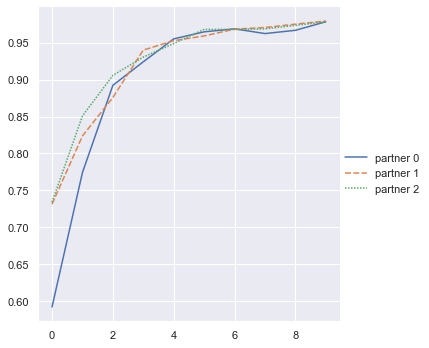

In [54]:
p0 = (x[:,0])
p1 = (x[:,1])
p2 = (x[:,2])

d = {
    'partner 0' : p0,
    'partner 1' : p1,
    'partner 2' : p2
}

df = pd.DataFrame(d)


sns.relplot(data = df, kind = "line")

### Now let's compare this result to our averaged model

In [55]:
x_collective = current_scenario.mpl.score_matrix_collective_models

print(x_collective)



[[0.06566667 0.55691665 0.75566667 0.78850001]
 [0.78850001 0.84675002 0.85641664 0.85833335]
 [0.85833335 0.89583331 0.91224998 0.91766667]
 [0.91766667 0.92975003 0.94941664 0.94599998]
 [0.94599998 0.95583332 0.96233332 0.95899999]
 [0.95899999 0.96583331 0.96608335 0.96950001]
 [0.96950001 0.97025001 0.97216666 0.97324997]
 [0.97324997 0.96899998 0.97933334 0.97858334]
 [0.97858334 0.977      0.98008335 0.97933334]
 [0.97933334 0.98141664 0.98133332 0.98058331]]


We will just focus ourselves on the first mini batch of each epoch again

          0
0  0.065667
1  0.788500
2  0.858333
3  0.917667
4  0.946000
5  0.959000
6  0.969500
7  0.973250
8  0.978583
9  0.979333


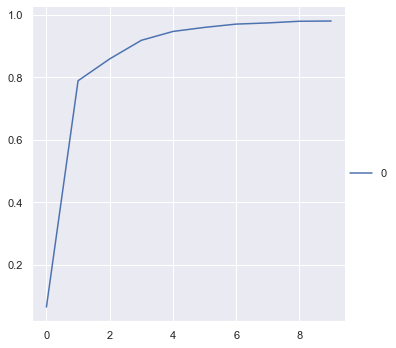

In [56]:
x_collective = x_collective[:,0]

df_collective = pd.DataFrame(x_collective)


print(df_collective)

sns.relplot(data = df_collective, kind = "line")

### Now let's compare this model to each partner's model :

In [57]:
d = {
    'partner 0' : p0,
    'partner 1' : p1,
    'partner 2' : p2,
    'Averaged model' : x_collective
}

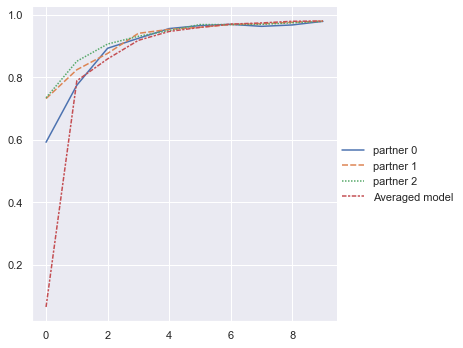

In [58]:
df = pd.DataFrame(d)


sns.relplot(data = df, kind = "line")

### Let's ommit the begining

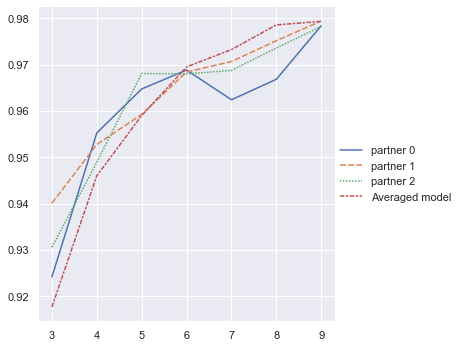

In [59]:
df = df.iloc[3:]
sns.relplot(data = df, kind = "line")

# The averaged model seems to perform poorly at the start but become better as the training continues